# MODERN Machine Learning

The way in which we go about developing an ML model should be easy for the developer to keep track of the prototypes, enable colloborative development with the team and should utilize the computing resources efficiently.  There are 3 key things that can help us practice the modern ML development process:
* Hyper-paramter tuning
* Experiment tracking
* Model output explainablility

I found that some techniques and libraries can help achieve these 3 things - which after initial exploration I have compiled this notebook. 

This is an intro to follow a ML development process which would make life a little bit easier.

In [ ]:
!pip install neptune-client==0.9.1

In [ ]:
!pip install neptune-contrib

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import preprocessing
from sklearn import model_selection
import optuna
from optuna import visualization
import eli5
from mlxtend import evaluate
import neptune
neptune.init('shared/sklearn-integration', api_token='ANONYMOUS')
from neptunecontrib.monitoring.sklearn import log_classifier_summary

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**BASIC EDA & CLEANUP**

In [ ]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

In [ ]:
print(df.dtypes)
print(df.isnull().sum())

There are no null/NaNs in the dataset - one less thing to worry about. 

However, the Total Charges column is of object datatype, but it consists of float values - have to convert it to float type

In [ ]:
#df["TotalCharges"] = df["TotalCharges"].astype(float)
df.iloc[488]

When I did usual typecasting using .astype (commented line) to convert the column to float, row 488 was sticking out as it was an empty string (as shown above). In such as case, setting coerce as True will make the it NaN during conversion, which is not ideal as I wanted to make it 0.0

To deal with this, any empty string has been converted to '0' string and then applied astype to get the intented outcome

(P.S: There can be better ways to deal with this error, if so then please let me know in the comments)

In [ ]:
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: 0 if x == ' ' else x)
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [ ]:
churn_map = {"Yes":1, "No":0}
df["Churn"] = df["Churn"].map(churn_map)
df["Churn"].value_counts()

The Target feature is converted to numeric using map

In [ ]:
y = df['Churn']
X = df.drop(['Churn', 'customerID'], axis=1)

In [ ]:
cat_list = list(X.select_dtypes(include=['object']).columns)

for i in range(len(cat_list)):
    X[cat_list[i]] = preprocessing.LabelEncoder().fit_transform(X[cat_list[i]])

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

# HYPER-PARAMETER TUNING

I made all the data preparation required to run the RandomForestClassifier. Now, it is time to find the best paramters so that I can optimize the model. For this, my go to choice would be GridSerachCV

In GridSearchCV, the search space of each hyper-parameter is discrete. The optimizer fits for each of the hyper-parameter configurations and selects the best combination that gives the highest score. Many a times, I have faced with a long wait for this process to complete as it take upto 500 fits depending on the defined parameter space. Moreover, the defined parameter space is limited and because of this the search is not very exhaustive as well.

**Now, Consider OPTUNA**

Optuna is a framework for automatic optimization process of these hyperparameters. It finds optimal hyperparameter values by making use of different samplers. Specifically, it employs a Bayesian optimization algorithm called Tree-structured Parzen Estimator. 

What is Bayesian Optimization? It build a probability model of the object function and builds a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function. The basic idea is spend a little more time selecting the next hyperparameters in order to make fewer calls to the objective function. Simply, Bayesian optimization methods are efficient as they choose the next hyperparameters in an informed manner. 


In [ ]:
def objective(trial, X, y):
    params = {
              'n_estimators': trial.suggest_int('n_estimators', 100, 500),
              'max_depth': trial.suggest_int('max_depth', 1, 30)
    }
    
    rf = ensemble.RandomForestClassifier(class_weight='balanced', random_state=42, **params)
    
    score = model_selection.cross_val_score(rf, X, y, scoring='accuracy', n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

In [ ]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(sampler = sampler, direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)

Here, I chose 2 paramters to optimize - n_estimators and max_depth:
* n_estimators - considers all the integers between 100 to 500
* max_depth - considers all integers between 1 to 30

In the traditional GridSearchCV method, this would take hours to run as I have defined exhaustive number of data points to consider. However, by using Optuna I ran only 10 trials in a matter of few seconds and was able to optimize the model. Ta da!

In [ ]:
print("The best value is ",study.best_value)
print("\nThe best parameters are ",study.best_params)

In [ ]:
visualization.plot_parallel_coordinate(study)

As a bonus, optuna has some helpful plots to visualize the contribution of the paramters. The plot above shows how the accuracy increased from 74% to 79% and the combination of paramaters that has led to the final score across the 10 runs

In [ ]:
clf = ensemble.RandomForestClassifier(**study.best_params, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)

# ML Experiment tracking

Experiment tracking is essential, as it allows us to focus on the development work and not maintaing the prototype versions and the metadata store.

**For this, NEPTUNE can be very helpful**

Some of the things that Neptune does: 
* Log and display metrics, parameters, images, and other ML metadata
* Share results by sending a persistent link
* Maintain data and associate model file

In [ ]:
neptune.create_experiment(params=study.best_params, name='classification-example', tags=['RandomForest', 'classification'])

In [ ]:
log_classifier_summary(clf, X_train, X_test, y_train, y_test)

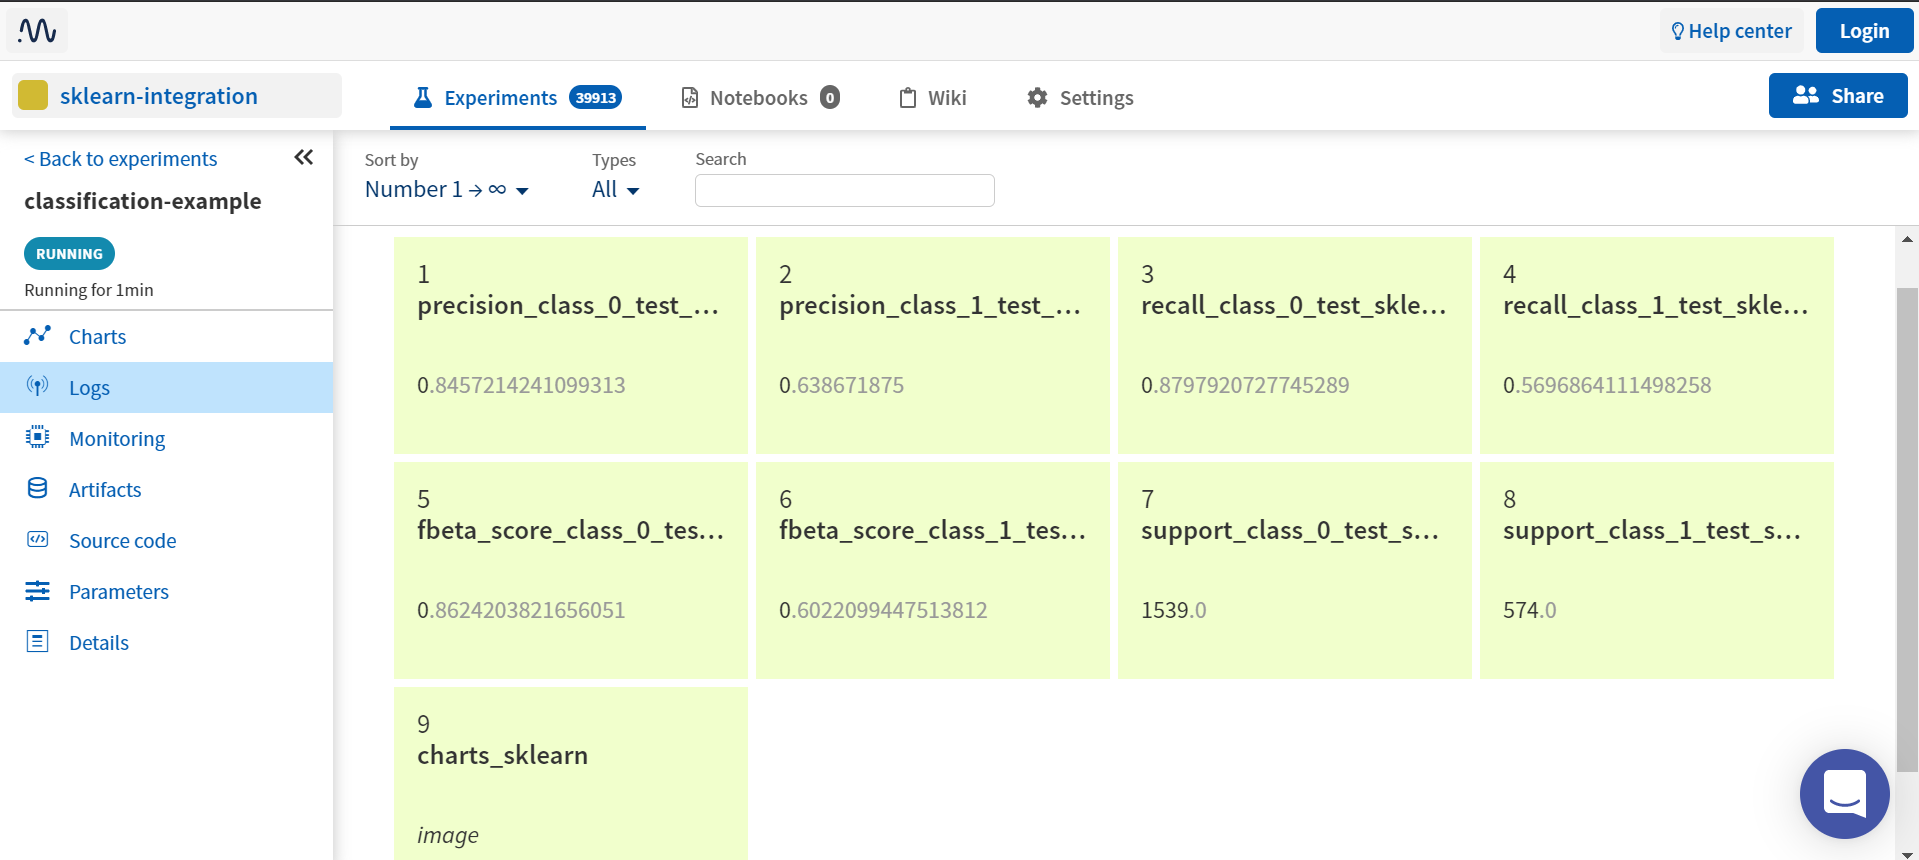

As shown above, Experiment tracking with Neptune logs all the essential metrics whenever the log_summary function is called

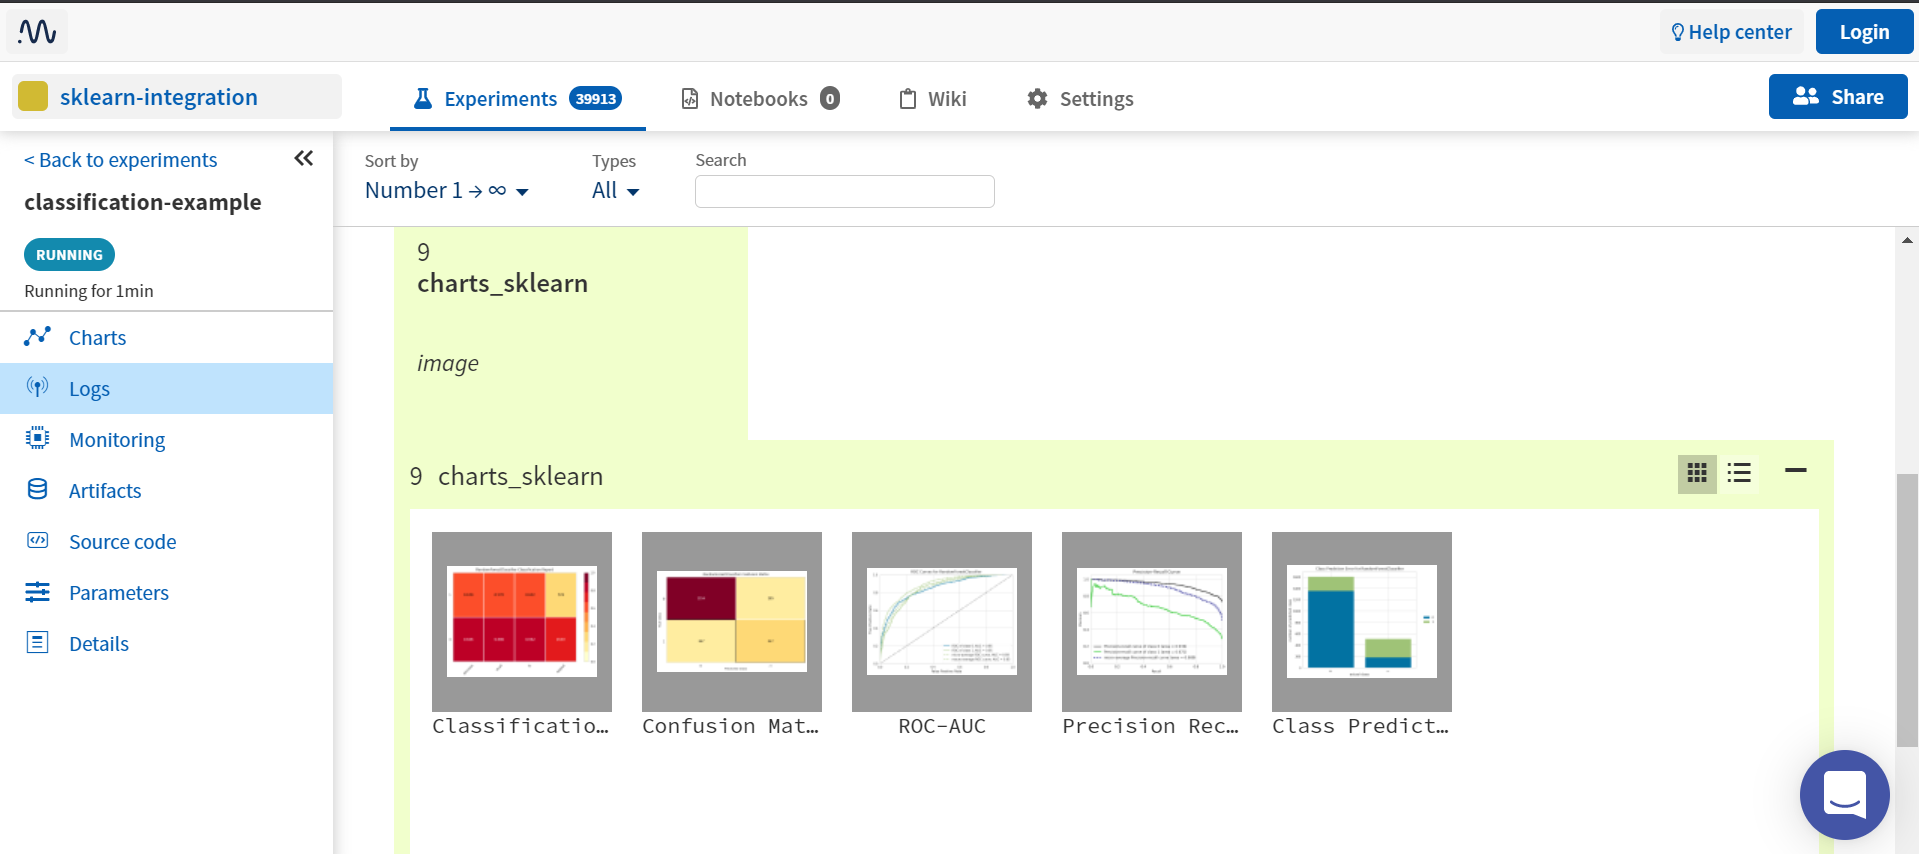

It also creates the confusion matrix, ROC-AUC curve, Precision-Recall curve and class prediction error grpahs automatically. This eliminated the need for me to plot and update these metrics and graphs for every iteration of the model training & testing phase.

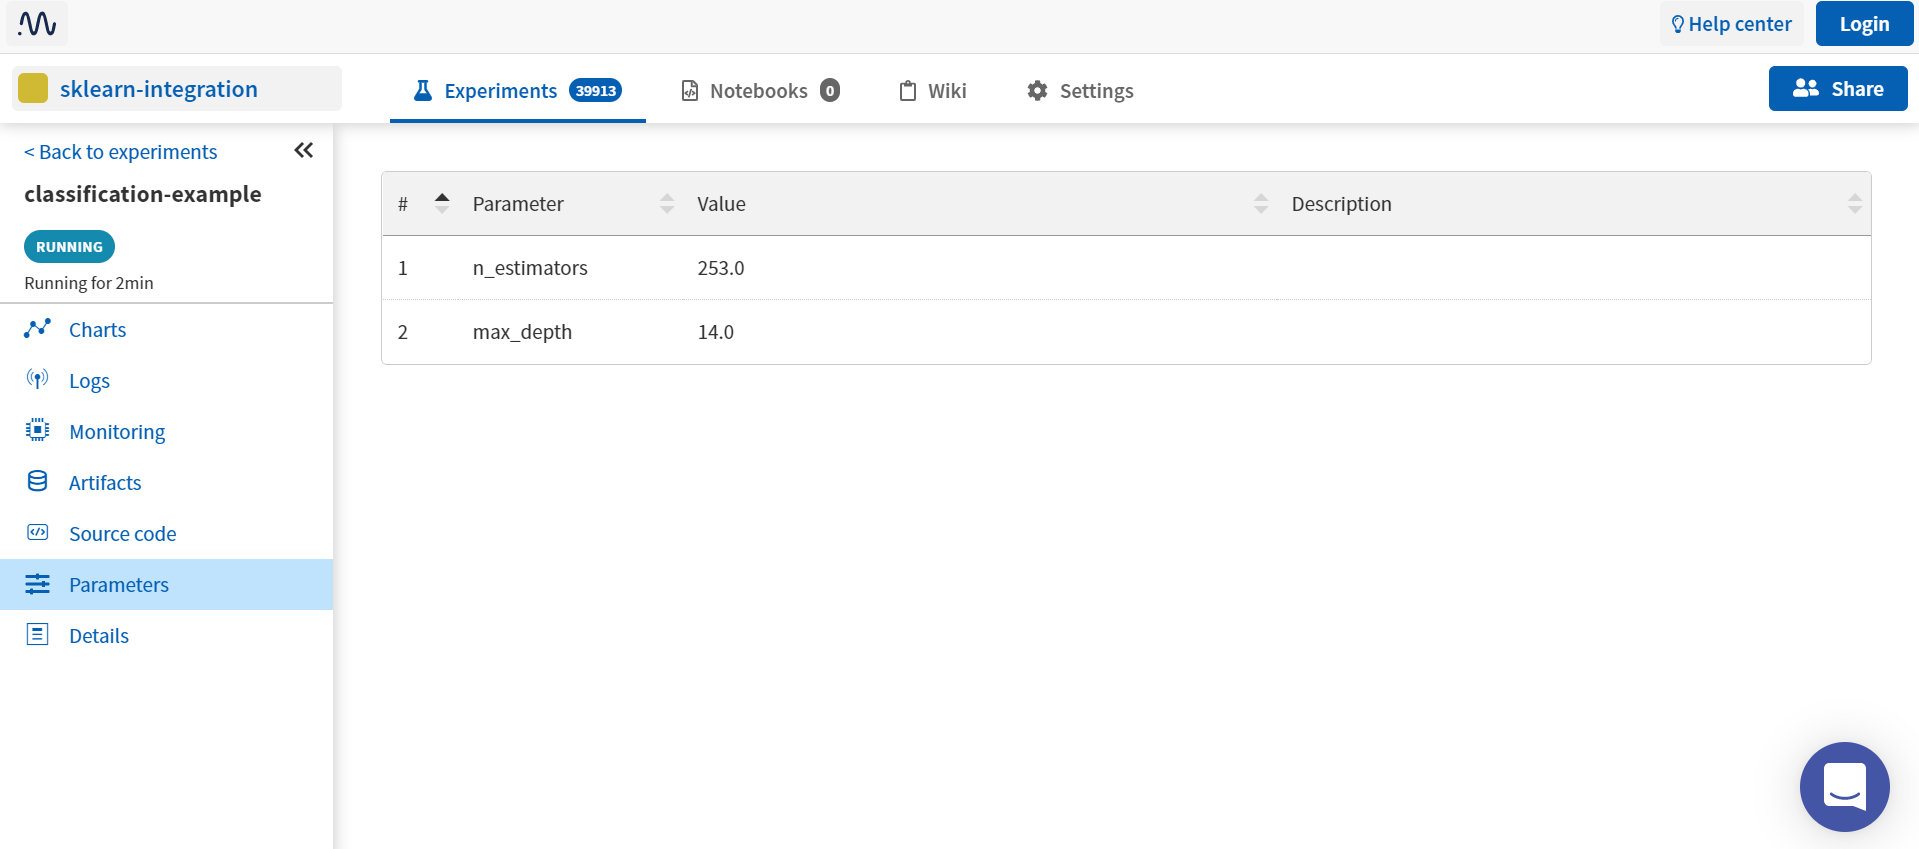

The parameters of the tuned model are also logged. 

I later noticed that the dataframe and the trained model file is also stored - have not included a sample image for this

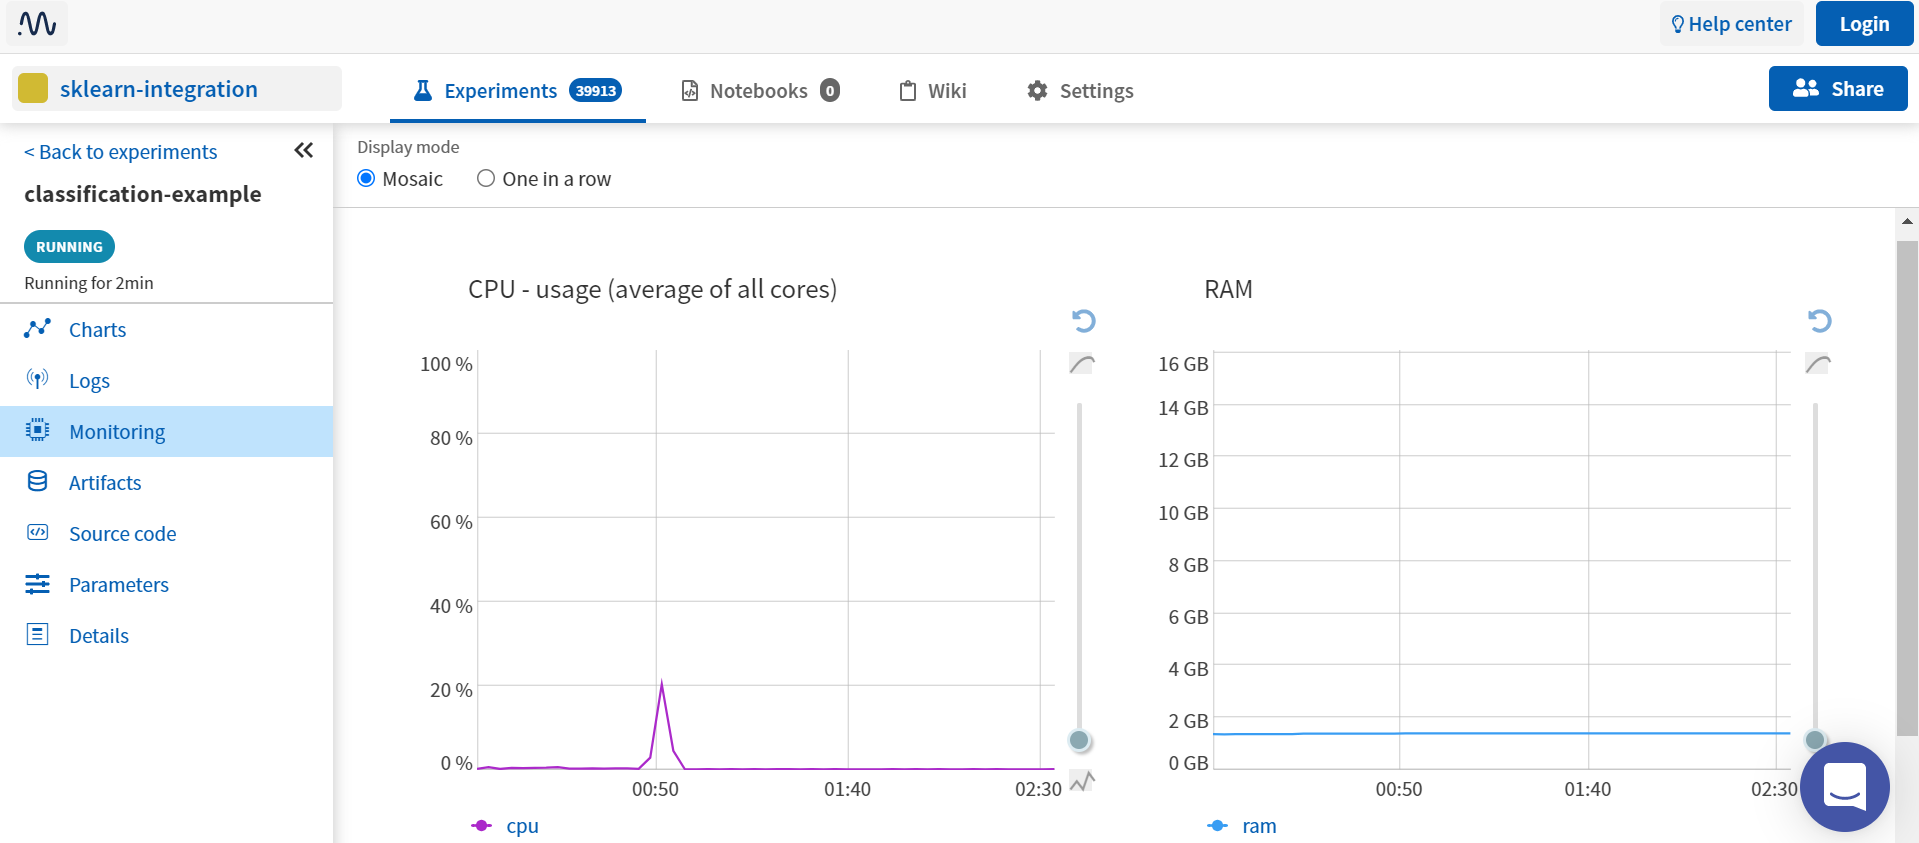

The CPU and RAM usage can also be monitored. This can be useful in the cases where a cloud platform charges us by the usgae amount, making resource tracking essential

In [ ]:
neptune.stop()

# EXPLAINABILITY

Demistifying and interpreting ML models and their outputs is criticial, as it enables us to debug the mode behaviour, explain the output to a stake-holder and fine tune to the specific use-case or domain.

**Here, I have focussed on Post-Hoc model explainability**

Post hoc interpretability refers to the application of interpretation methods after model training

In [ ]:
eli5.show_prediction(clf, X_test.iloc[0], feature_names=list(X_test.columns),show_feature_values=True, top=7)

In [ ]:
eli5.show_prediction(clf, X_test.iloc[5], feature_names=list(X_test.columns),show_feature_values=True, top=7)

Using ELI5 library, I was able to get the predictions for specific data points and the top factors that contribute to the prediction probabaility. 

As shown, for both the class 0 and 1, the highest contributing factor is tenure, meaning that the feature is important to our classification

There are more interpretability techniques - which are not included here

**I learned these techniques as I was writing this notebook. I intend to explore further and drill-down on each of tuning, tracking and explainablility to learn more**

**I will make individual notebooks sharing my learnings on the depth of these topics, with more libraries and references if possible**


**I hope you liked this notebook. If so, please consider to upvote it. Cheers !!**